# Phase Diagram for the Syntectic System

Here we develop a free energy functional and phase diagram for a system with a syntectic transition

## Ideal Free Energy

---

The ideal free energy per unit area is of the following form

$$
\mathcal{F}_{id}[n] = \frac{1}{V_{cell}}\int_{cell} 
\frac{1}{2}n(x,y)^2 - \frac{\eta}{6} n(x,y)^3 + \frac{\chi}{12} n(x,y)^4
$$

To compute the phase diagram we use a variational method where we expand the reduced density, $n$, in the most general fourier series that is consistent with the symmetry of the bravais lattice.

$$
n(x,y) = n_0 + A_1 n_1(x,y) + A_2 n_2(x,y) + ...
$$

We then expand out the ansatz and compute each integral over the unit-cell numerically to find the amplitude equation for the ideal free energy

In [1]:
using PyPlot
using Interact
using Maxima
using Optim
using PhaseDiagrams

Connecting Maxima to server on port 8080


In [2]:
f_ideal = m"n^2/2 - η*n^3/6 + χ*n^4/12"

 
                                4      3      2
                               n  χ   n  η   n
                               ---- - ---- + --
                                12     6     2

In [3]:
n = m"n0 + 2*A*n1"            # + A[2]*n2"

f_ideal = subst(n, :n, f_ideal)

 
                          4                  3                  2
             (2 A n1 + n0)  χ   (2 A n1 + n0)  η   (2 A n1 + n0)
             ---------------- - ---------------- + --------------
                    12                 6                 2

In [4]:
f_ideal = expand(f_ideal)

 
    4   4        3      3                            3          4
 4 A  n1  χ   8 A  n0 n1  χ      2   2   2     2 A n0  n1 χ   n0  χ
 ---------- + ------------- + 2 A  n0  n1  χ + ------------ + -----
     3              3                               3          12
      3   3                                    3                              2
   4 A  n1  η      2      2         2        n0  η      2   2               n0
 - ---------- - 2 A  n0 n1  η - A n0  n1 η - ----- + 2 A  n1  + 2 A n0 n1 + ---
       3                                       6                             2

In [5]:
n1 = m"cos(4*%pi/sqrt(3)*(sqrt(3)*x/2 - y/2)) + 
       cos(4*%pi/sqrt(3)*(sqrt(3)*x/2 + y/2)) + 
       cos(4*%pi/sqrt(3)*y)"

n2 = m"cos(4*%pi*x) +
       cos(4*%pi*(x/2 + sqrt(3)*y/2)) + 
       cos(4*%pi*(-x/2 + sqrt(3)*y/2))"

f_ideal = subst(n1, :n1, f_ideal)
#f_ideal = subst(n2, :n2, f_ideal);

In [6]:
F_ideal = "integrate(integrate($f_ideal, x, 0, 1), y, 0, sqrt(3)/2)" |> MExpr;

In [7]:
F_ideal = mcall(F_ideal)

 
            3/2       4       7/2      2   2       5/2      3
 ((- ((- 2 3    %pi n0 ) - 8 3    %pi A  n0  - 32 3    %pi A  n0
       7/2      4           3/2       3      7/2      2          5/2      3
 - 20 3    %pi A ) χ) - (4 3    %pi n0  + 8 3    %pi A  n0 + 16 3    %pi A ) η
      5/2       2      7/2      2
 + 4 3    %pi n0  + 8 3    %pi A )/(144 %pi)

In [8]:
F_ideal = ratsimp(F_ideal)
F_ideal = "$F_ideal/(sqrt(3)/2)" |> MExpr |> mcall
F_ideal = ratsimp(F_ideal)
F_ideal = float(F_ideal)
F_ideal = expand(F_ideal)

 
                       4          2   2          3             4
 0.08333333333333333 n0  χ + 3.0 A  n0  χ + 4.0 A  n0 χ + 7.5 A  χ
                                3          2             3           2        2
         - 0.1666666666666667 n0  η - 3.0 A  n0 η - 2.0 A  η + 0.5 n0  + 3.0 A

In [9]:
F_id_exp = parse(F_ideal)                # Make julia expression of the ideal free energy
@eval F_id(η, χ, n0, A) = $F_id_exp     # Make julia function from the expression

F_id (generic function with 1 method)

Interact.Slider{Float64}(Signal{Float64}(1.4, nactions=0),"η",1.4,1.0:0.1:1.8,true)

Interact.Slider{Float64}(Signal{Float64}(0.1, nactions=0),"n0",0.1,0.0:0.01:0.2,true)

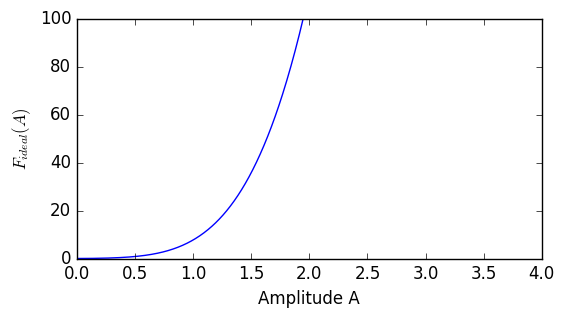

In [10]:
let
    A = linspace(0.0, 4.0, 1000)
    ff = Array(Float64, 1000)
    f = figure(figsize=(6, 3))

    @manipulate for η in 1.0:0.1:1.8, n0 in 0.0:0.01:0.2
        withfig(f) do
            for i in 1:1000
                ff[i] = F_id(η, 1.0, n0, A[i])
            end
            plot(A, ff)
            ylim(0, 100)
            xlabel("Amplitude A")
            ylabel(L"F_{ideal}(A)")
        end
    end
end

## Free Energy of Mixing

The free energy of mixing is of the following form:

$$
    \mathcal{F}_{mix}[c] = \frac{\omega}{V_{cell}}\int_{cell} 
    (1 + n_0)\left(c \log\left(\frac{c}{c_0}\right) + 
    (1-c) \log\left(\frac{1-c}{1-c_0}\right)\right) + \frac{\epsilon(T)}{2}(c-c_0)^2
$$

In equilibrium we can assume that the concentration is constant so the integral just cancels the factor of the volume of the unit cell. The term $\epsilon(T)$ is the enthaply of mixing term which we model as, 

$$
\epsilon(T) = -4 + \epsilon_0 (T - T_0),
$$

where $T_0$ is the spinodal temperature of the liquid

In [11]:
 F_mix(c, T, n₀, ϵ₀, T₀, ω) = ω*((1+n₀)*(c*log(2.0*c) + (1-c)*log(2.0*(1-c))) + (-4.0 + ϵ₀*(T-T₀))/2*(c-0.5)^2)

F_mix (generic function with 1 method)

Interact.Slider{Float64}(Signal{Float64}(0.2, nactions=0),"ω",0.2,0.0:0.01:0.4,true)

Interact.Slider{Float64}(Signal{Float64}(0.3, nactions=0),"T",0.3,0.0:0.01:0.6,true)

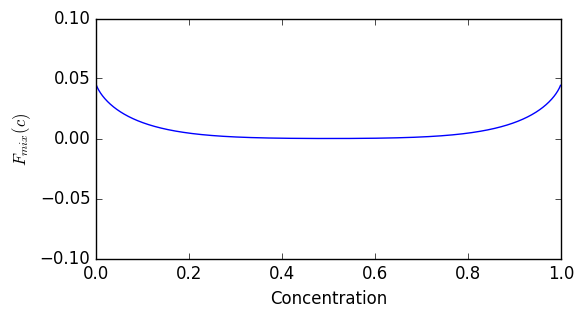

In [12]:
let
    N = 1000
    c = linspace(0.001, 0.999, N)
    ff = Array(Float64, N)
    f = figure(figsize=[6, 3])
    @manipulate for ω in 0.0:0.01:0.4, T in 0.0:0.01:0.60
        withfig(f) do
            for i in 1:N
                ff[i] = F_mix(c[i], T, 0.05, 20.0, 0.30, ω)
            end
            plot(c, ff)
            xlim(0, 1)
            ylim(-0.1, 0.1)
            xlabel("Concentration")
            ylabel(L"F_{mix}(c)")
        end
    end
end

## Correlation functions

There are a variety of effective pair correlation functions we can choose from. Here is one of them from the original xpfc paper

In [31]:
k′ = 2π
α = 0.8
β = 6.0
ρ = sqrt(3)/2.0
αc = 0.2
c₀ = 0.5

C_eff(k, c, T) = exp(-(c-1.)^2/(2*(αc)^2))*exp(-T^2*k′^2/(2*β*ρ))*exp(-(k-k′)^2/(2*α^2))

function find_k(c, T)
    sol = optimize(k -> -C_eff(k, c, T), 2π, 4π/√3)
    k₀ = float(sol.minimum)
    return k₀
end

find_k (generic function with 1 method)

In [32]:
k = find_k(1.0, 0.4)

6.283185413109935

Interact.Slider{Float64}(Signal{Float64}(0.5, nactions=0),"c",0.5,0.0:0.01:1.0,true)

Interact.Slider{Float64}(Signal{Float64}(0.5, nactions=0),"T",0.5,0.0:0.01:1.0,true)

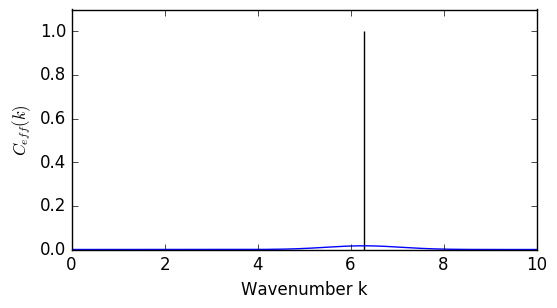

In [33]:
let
    N = 400
    k = linspace(0.0, 10.0, N)
    CC = Array(Float64, N)
    f = figure(figsize=[6, 3])
    @manipulate for c in 0.0:0.01:1.0, T in 0.0:0.01:1.0
        withfig(f) do
            for i in 1:N
                CC[i] = C_eff(k[i], c, T)
            end
            kmax = find_k(c, T)
            plot(k, CC)
            vlines(kmax, 0.0, 1.0)
            xlim(0, 10)
            ylim(0, 1.1)
            xlabel("Wavenumber k")
            ylabel(L"$C_{eff}(k)$")
        end 
    end
end

## Excess Free Energy

The excess free energy term in the binary phase field crystal model is the form

$$
\mathcal{F}_{ex}[n, c] = -\frac{1}{2 V_{cell}}\int_{cell} dr \int dr^\prime n(r) C_{eff}(r, r^\prime; c) n(r^\prime)
$$

Most of the modes in the amplitude expansion cancel out but we're left with the following at the end of the day:

$$
\mathcal{F}_{ex}[n, c] = -\frac{1}{2 V_{cell}}(n_0^2 C_{eff}(k=0, c) + 6 A_1^2 C_{eff}(k=k_1, c) + 6 A_2^2 C_{eff}(k=k_2, c))
$$

In [34]:
function F_ex(c, T, A)
    k = find_k(c, T)
    return (-3.0*A^2*C_eff(k, c, T))       # + 6.0*A[2]^2*C_eff(k[2], c, T))
end

F_ex (generic function with 1 method)

In [35]:
## Vcell Hackery
k = find_k(1.0, 0.0)
Vcell = √3/2*(4π/(k*√3))^2

println("Vcell = $Vcell, Vcell = $(√3/2)")

Vcell = 1.1547004994442778, Vcell = 0.8660254037844386


Interact.Slider{Float64}(Signal{Float64}(2.0, nactions=0),"η",2.0,1.0:0.1:3.0,true)

Interact.Slider{Float64}(Signal{Float64}(0.491, nactions=0),"c",0.491,0.001:0.01:0.991,true)

Interact.Slider{Float64}(Signal{Float64}(0.15, nactions=0),"T",0.15,0.0:0.01:0.3,true)

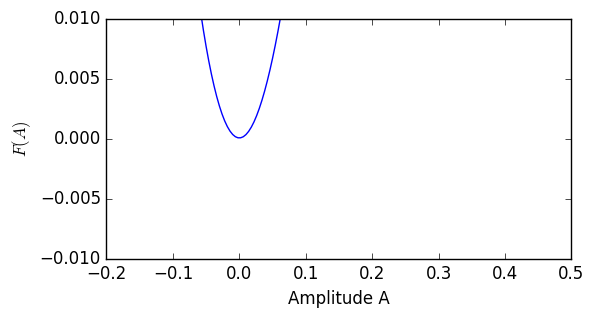

In [36]:
let
    N = 1000
    A = linspace(-2.0, 2.0, N)
    ff = Array(Float64, N)
    f = figure(figsize=(6, 3))
    n₀ = 0.0
    ϵ₀ = 20.0
    T₀ = 0.30
    ω = 0.02
    @manipulate for η in 1.0:0.1:3.0, c in 0.001:0.01:0.999, T in 0.0:0.01:0.3
        withfig(f) do
            for i in 1:N
                ff[i] = F_ex(c, T, A[i]) + F_id(η, 1.0, 0.01, A[i]) + F_mix(c, T, n₀, ϵ₀, T₀, ω)
            end
            plot(A, ff)
            ylim(-0.01,0.01)
            xlim(-0.2, 0.5)
            xlabel("Amplitude A")
            ylabel(L"F(A)")
        end
    end
end

## Total free energy

The total free energy is sum of all the above terms

In [37]:
F(c, T, η, χ, ϵ₀, T₀, ω, n₀, A) = F_mix(c, T, n₀, ϵ₀, T₀, ω) + F_ex(c, T, A)+ F_id(η, χ, n₀, A) 

F (generic function with 3 methods)

In [38]:
function F(c, T, η, χ, ϵ₀, T₀, ω, n₀)
    sol = optimize(A -> F(c, T, η, χ, ϵ₀, T₀, ω, n₀, A), 0.0, 10.0)
    #println("Amplitude at concentation $c and temperature $T is $(sol.minimum)")
    return sol.f_minimum
end

F (generic function with 3 methods)

Interact.Slider{Float64}(Signal{Float64}(0.4901, nactions=0),"c",0.4901,0.0001:0.01:0.9901,true)

Interact.Slider{Float64}(Signal{Float64}(0.1, nactions=0),"T",0.1,0.0:0.001:0.2,true)

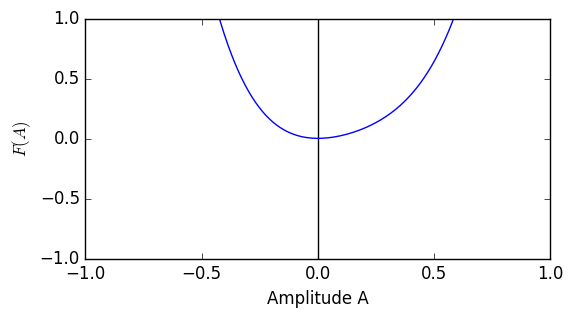

In [39]:
let
    N = 1000
    A = linspace(-2.0, 3.0, N)
    ff = Array(Float64, N)
    f = figure(figsize=(6, 3))
    η = 2.0
    χ = 1.0
    local ϵ₀ = 0.0
    local T₀ = 0.0
    n₀ = 0.05
    ω = 0.02
    @manipulate for c in 0.0001:0.01:0.9999, T in 0.0:0.001:0.20
        withfig(f) do
            for i in 1:N
                ff[i] = F(c, T, η, χ, ϵ₀, T₀, ω, n₀, A[i])
            end
            A_min = optimize(A -> F(c, T, η, χ, ϵ₀, T₀, ω, n₀, A), 0.0, 7.0).minimum
            plot(A, ff)
            vlines(A_min, -1, 1)
            ylim(-1,1)
            xlim(-1, 1)
            xlabel("Amplitude A")
            ylabel(L"F(A)")
        end
    end
end

Interact.Slider{Float64}(Signal{Float64}(0.2, nactions=0),"T",0.2,0.0:0.001:0.4,true)

Interact.Slider{Float64}(Signal{Float64}(2.0, nactions=0),"η",2.0,1.0:0.1:3.0,true)

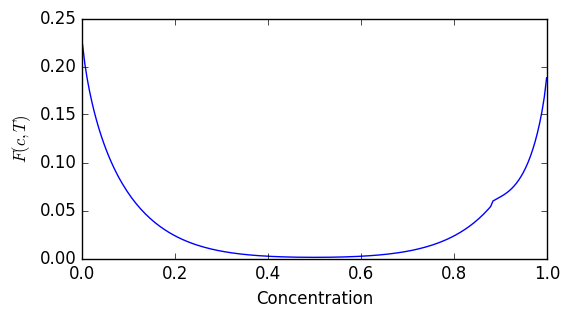

In [40]:
let
    N = 200
    c = linspace(0.001, 0.999, N)
    ff = Array(Float64, N)
    f = figure(figsize=[6, 3])
    const χ = 1.0
    const ϵ₀= 10.0
    const T₀= 0.20
    const n₀ = 0.05
    const ω = 1.0
    @manipulate for T in 0.0:0.001:0.4, η in 1.0:0.1:3.0
        withfig(f) do
            for i in 1:N
                ff[i] = F(c[i], T, η, χ, ϵ₀, T₀, ω, n₀)
            end
            plot(c, ff)
            xlim(0, 1)
            xlabel("Concentration")
            ylabel(L"F(c, T)")
        end
    end
end

In [23]:
pygui(false)

false

In [24]:
const η = 2.0
const χ = 1.0
const ϵ₀ = 10.0
const T₀ = 0.20
const ω = 0.3
const n₀ = 0.05

F(c, T) = F(c, T, η, χ, ϵ₀, T₀, ω, n₀)

F (generic function with 3 methods)

In [25]:
function make_phase_diagram(crnge, Trnge)
    T_vals = Float64[] 
    c_vals = Float64[]
    
    c = collect(crnge)
    T = collect(Trnge)
    
    f = Array(Float64, length(c))
    
    for t in 1:length(T)
        for cc in 1:length(c)
            f[cc] = F(c[cc], T[t])
        end
        arr = commontangent(f)
        for domain in arr
            for point in domain
                push!(T_vals, T[t])
                push!(c_vals, c[point])
            end
        end
    end
    return T_vals, c_vals
end

make_phase_diagram (generic function with 1 method)

In [26]:
crnge = 0.001:0.001:0.999
Trnge = 0.00:0.010:0.35

T_vals, c_vals = make_phase_diagram(crnge, Trnge)

([0.0,0.0,0.01,0.01,0.02,0.02,0.03,0.03,0.04,0.04  …  0.25,0.25,0.26,0.26,0.27,0.27,0.28,0.28,0.29,0.29],[0.052,0.942,0.055,0.94,0.059,0.938,0.063,0.936,0.067,0.934  …  0.815,0.893,0.851,0.905,0.875,0.922,0.905,0.944,0.955,0.979])

In [27]:
f = figure()
withfig(f) do
    scatter(c_vals, T_vals, c="k")
    grid(false)
    xlim(0, 1)
    ylim(0.00, 0.40)
    xlabel(L"Concentration $(c)$")
    ylabel(L"Temperature $(T)$")
    title("Nanocrystalline Phase Diagram")
end

savefig("Nanocrystalline Phase Diagram.svg")

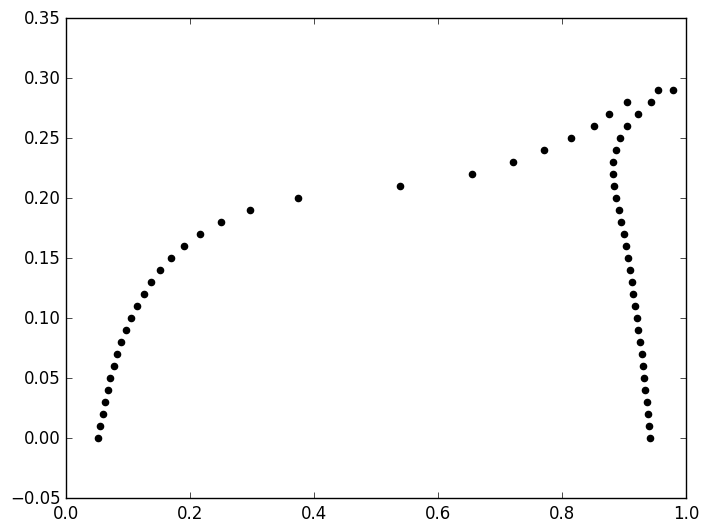

In [28]:
scatter(c_vals, T_vals, c="k")
xlim(0, 1)
grid(false)